In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
retail_df = pd.read_csv("/content/drive/MyDrive/colab/Data Science/dataset-3.csv",delimiter=",")
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010/12/1 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010/12/1 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010/12/1 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010/12/1 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010/12/1 08:26,3.39,17850.0,United Kingdom


### Preprocessing  
There is a little cleanup, we need to do. First, some of the descriptions have spaces that need to be removed. We’ll also drop the rows that don’t have invoice numbers and remove the credit transactions (those with invoice numbers containing C).

In [3]:
#remove some of descriptions have spaces.
retail_df['Description'] = retail_df['Description'].str.strip()

#remove NA values
retail_df.dropna(axis=0, subset=['InvoiceNo'], inplace=True)

#remove cancelled orders
retail_df['InvoiceNo'] = retail_df['InvoiceNo'].astype('str')
retail_df = retail_df[~retail_df['InvoiceNo'].str.contains('C')]

In [4]:
#choose country
retail_df_france = retail_df[retail_df['Country'] == 'France']

### RFM Segmentation
RFM is a data modeling method used to analyze customer value. It stands for recency, frequency, and monetary, which are just three metrics that describe what your customers did.

Recency (R) of a customer: Days since the last purchase.  
Frequency (F) of the bookings/turnover of a customer, e.g. Number of purchases in 6 months.  
Monetary (M) - The total turnover of a customer, e.g. Sum of sales in 6 months.  

Recency 反應的是顧客的活躍度  
Frequency 能幫你找到持續購物的顧客  
Monetary 幫你分辨真正的「貴客」  

In [5]:
# Monetary
retail_df_france['Monetary'] = retail_df_france['Quantity'] * retail_df_france['UnitPrice']

#caculate total Monetary of each custoner
Monetary_df = retail_df_france.groupby('CustomerID')['Monetary'].sum()
Monetary_df = Monetary_df.reset_index()
Monetary_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,CustomerID,Monetary
0,12413.0,758.10
1,12437.0,4951.41
2,12441.0,173.55
3,12488.0,1298.66
4,12489.0,334.93


In [6]:
# caculate recency of each customer
# convert to datetime 
retail_df_france['InvoiceDate'] = pd.to_datetime(retail_df_france['InvoiceDate'],format='%Y-%m-%d %H:%M')

# compute the max date,That is, the most recent consumption date
max_date = max(retail_df_france['InvoiceDate'])

# compute the diff
retail_df_france['diff'] = max_date - retail_df_france['InvoiceDate']
# only use the number of day
retail_df_france['diff'] = retail_df_france['diff'].dt.days

# recency
recency_df = retail_df_france.groupby('CustomerID')['diff'].min()
recency_df = recency_df.reset_index()
recency_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

,CustomerID,diff
0,12413.0,66
1,12437.0,1
2,12441.0,366
3,12488.0,9
4,12489.0,335
...,...,...
82,12734.0,352
83,12735.0,314
84,12736.0,332
85,12740.0,63


In [7]:
# frequency
# Some data sets only have invoices but do not show customers

Cust_freq = retail_df_france[['InvoiceNo','CustomerID']].drop_duplicates()

#Calculating the count of unique purchase for each customer
frequency_df = Cust_freq.groupby(['CustomerID'])['InvoiceNo'].aggregate('count')
frequency_df = frequency_df.reset_index()
frequency_df.columns = ['CustomerID', 'frequency']
frequency_df

,CustomerID,frequency
0,12413.0,3
1,12437.0,18
2,12441.0,1
3,12488.0,3
4,12489.0,1
...,...,...
82,12734.0,1
83,12735.0,2
84,12736.0,1
85,12740.0,1


In [8]:
#merge dataframe
df1 = pd.merge(recency_df,frequency_df)
rfm_df = pd.merge(df1,Monetary_df)

rfm_df.columns = ['CustomerID','Recency','Frequency','Monetary']
rfm_df

,CustomerID,Recency,Frequency,Monetary
0,12413.0,66,3,758.10
1,12437.0,1,18,4951.41
2,12441.0,366,1,173.55
3,12488.0,9,3,1298.66
4,12489.0,335,1,334.93
...,...,...,...,...
82,12734.0,352,1,110.40
83,12735.0,314,2,779.57
84,12736.0,332,1,234.00
85,12740.0,63,1,427.60


### Normaize data
Normalizing dataset so that each metric (Recency, Frequency, and Monetary) is from the same scale.  
Without standardization, the clustering algorithm could be biased since Monetary might be much higher than the other two variables

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler()
scaler.fit(rfm_df)

rfm_standard = scaler.transform(rfm_df) #array 
#convey array to dataframe and set columns,index
rfm_standard = pd.DataFrame(data = rfm_standard , index = rfm_df.index, columns = rfm_df.columns)

rfm_standard = rfm_standard[['Monetary','Recency','Frequency']]

In [10]:
rfm_standard

,Monetary,Recency,Frequency
0,0.036372,0.177898,0.066667
1,0.259154,0.002695,0.566667
2,0.005315,0.986523,0.000000
3,0.065090,0.024259,0.066667
4,0.013889,0.902965,0.000000
...,...,...,...
82,0.001960,0.948787,0.000000
83,0.037512,0.846361,0.033333
84,0.008527,0.894879,0.000000
85,0.018813,0.169811,0.000000


### K-means algorithm for clustering

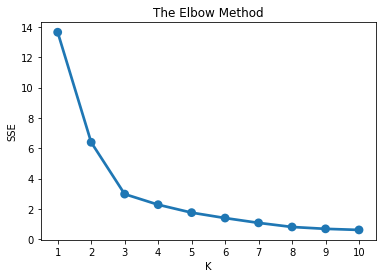

In [11]:
#use elbow method to determine the number of clustering
from sklearn.cluster import KMeans
import seaborn as sns

#fit KMeans and calculate SSE for each K
sse = []
for k in range(1,11):
	kmeans = KMeans(n_clusters = k, random_state=1)
	kmeans.fit(rfm_standard)
	sse.append(kmeans.inertia_) 

#plot SSE for each K
plt.title('The Elbow Method')
plt.xlabel('K'); plt.ylabel('SSE')
sns.pointplot(x= list(range(1,11)) , y = sse)
plt.show()

### Fit k-means model

In [12]:
kmeans = KMeans(n_clusters = 3, random_state=1)
kmeans.fit(rfm_standard)
#extract cluster labels from labels_ attribute
cluster_labels = kmeans.labels_

cluster_rfm_df = rfm_standard.assign(Cluster = cluster_labels)
cluster_rfm_df

,Monetary,Recency,Frequency,Cluster
0,0.036372,0.177898,0.066667,2
1,0.259154,0.002695,0.566667,0
2,0.005315,0.986523,0.000000,1
3,0.065090,0.024259,0.066667,2
4,0.013889,0.902965,0.000000,1
...,...,...,...,...
82,0.001960,0.948787,0.000000,1
83,0.037512,0.846361,0.033333,1
84,0.008527,0.894879,0.000000,1
85,0.018813,0.169811,0.000000,2


### Visualize clustering results

Text(0.5, 0, 'Frequency')

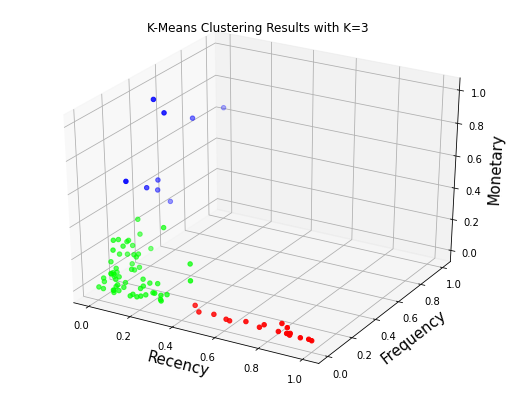

In [13]:
fig=plt.figure()
fig.set_size_inches(9, 7)
ax =fig.add_subplot(111,projection='3d') 
ax.set_title('K-Means Clustering Results with K=3')
ax.scatter(cluster_rfm_df['Recency'],cluster_rfm_df['Frequency'], cluster_rfm_df['Monetary'] ,cmap='brg',c=cluster_rfm_df['Cluster']);
ax.set_zlabel(r'Monetary', fontsize=15)
plt.xlabel('Recency',fontsize=15)
plt.ylabel('Frequency',fontsize=15)

In [14]:
import plotly.express as px
from plotly.offline import iplot

fig = px.scatter_3d(cluster_rfm_df, x='Recency',y='Frequency', z='Monetary',color='Cluster')
iplot(fig) 

In [15]:
#summary of clustering results
rfm_df['Cluster'] = cluster_rfm_df['Cluster']
summary = rfm_df.groupby(['Cluster']).agg({
    'Recency':'mean',
    'Frequency':'mean',
    'Monetary':['mean','count']
    })
summary

Recency  Frequency      Monetary      
               mean       mean          mean count
Cluster                                           
0         16.777778  15.333333  11701.400000     9
1        289.944444   1.111111    318.321667    18
2         38.866667   3.850000   1633.027667    60

### Conclusion
From the table above, Cluster 0 is your most loyal customer.they have visited your business 15.3 times, which is way higher than the other two groups,and most importantly, Cluster 0 customers have spent $11701.4

In [16]:
loyal_customer = rfm_df[rfm_df['Cluster']==0]
loyal_customer

,CustomerID,Recency,Frequency,Monetary,Cluster
1,12437.0,1,18,4951.41,0
16,12536.0,42,3,12601.83,0
20,12567.0,22,10,9401.28,0
26,12583.0,2,15,7281.38,0
52,12678.0,41,12,17628.46,0
55,12681.0,14,22,13787.54,0
56,12682.0,3,31,12288.22,0
57,12683.0,3,15,8476.57,0
80,12731.0,23,12,18895.91,0
